In [238]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE

In [239]:
WINDOW = 16 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock
ROWS_TO_PREDICT = 64
# one day 16 rows of data

In [240]:
data = pd.read_csv('C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\preprocess\\APPLE_22_03_2021 21_56_34.csv')

In [241]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
0,56.220000,56.220000,55.500000,55.600000,55.600000,0
1,55.550000,56.095000,55.370000,55.700000,55.700000,0
2,56.032500,56.437500,55.937500,56.247500,56.247500,0
3,56.132500,56.750000,56.042500,56.595000,56.595000,0
4,56.550000,58.197500,55.625000,57.812500,57.812500,0
5,57.837500,59.525000,56.887500,57.020000,57.020000,0
6,56.299999,56.750000,54.823750,55.450001,55.450001,21473989
7,55.465000,55.889999,53.412498,53.767502,53.767502,11306818
8,53.762501,55.097500,53.152500,54.803925,54.803925,11355189
9,54.823875,56.775002,54.472500,55.486252,55.486252,10671797


<AxesSubplot:>

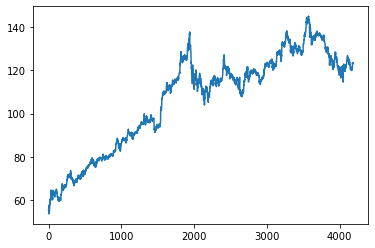

In [242]:
data['close'].plot()

In [243]:
data.head()

,open,high,low,close,Adj Close,volume
0,56.2200,56.2200,55.5000,55.6000,55.6000,0
1,55.5500,56.0950,55.3700,55.7000,55.7000,0
2,56.0325,56.4375,55.9375,56.2475,56.2475,0
3,56.1325,56.7500,56.0425,56.5950,56.5950,0
4,56.5500,58.1975,55.6250,57.8125,57.8125,0


In [244]:
data.describe()

,open,high,low,close,Adj Close,volume
count,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000,4.183000e+03
mean,106.643887,107.166827,106.048708,106.644971,106.644971,4.714023e+06
std,22.417863,23.119607,22.318330,22.402033,22.402033,8.307361e+06
min,53.762501,55.097500,50.978220,53.767502,53.767502,0.000000e+00
25%,88.078750,88.337500,87.816251,88.085000,88.085000,0.000000e+00
50%,114.907500,115.240000,114.200000,114.900000,114.900000,0.000000e+00
75%,123.514999,124.200000,122.829999,123.482502,123.482502,7.035940e+06
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07


In [245]:
data

,open,high,low,close,Adj Close,volume
0,56.220000,56.220000,55.500000,55.600000,55.600000,0
1,55.550000,56.095000,55.370000,55.700000,55.700000,0
2,56.032500,56.437500,55.937500,56.247500,56.247500,0
3,56.132500,56.750000,56.042500,56.595000,56.595000,0
4,56.550000,58.197500,55.625000,57.812500,57.812500,0
...,...,...,...,...,...,...
4178,123.425003,123.769997,123.040001,123.091103,123.091103,12373575
4179,123.090103,123.720001,123.080002,123.542000,123.542000,9430925
4180,123.544998,123.870003,123.275002,123.345001,123.345001,11354023
4181,123.339996,123.599998,123.019997,123.370003,123.370003,10684835


In [246]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume'], dtype='object')

In [247]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.5:
        return 1
    if row['close_shift'] -row['close']< -1.5:
        return -1
    else:
        return 0

In [248]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,open,high,low,close,Adj Close,volume,close_shift
0,56.220000,56.220000,55.500000,55.600000,55.600000,0,56.8750
1,55.550000,56.095000,55.370000,55.700000,55.700000,0,58.4475
2,56.032500,56.437500,55.937500,56.247500,56.247500,0,58.5500
3,56.132500,56.750000,56.042500,56.595000,56.595000,0,59.2225
4,56.550000,58.197500,55.625000,57.812500,57.812500,0,58.3075
...,...,...,...,...,...,...,...
4178,123.425003,123.769997,123.040001,123.091103,123.091103,12373575,NaN
4179,123.090103,123.720001,123.080002,123.542000,123.542000,9430925,NaN
4180,123.544998,123.870003,123.275002,123.345001,123.345001,11354023,NaN
4181,123.339996,123.599998,123.019997,123.370003,123.370003,10684835,NaN


In [249]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,open,high,low,close,Adj Close,volume,close_shift,class_column
0,56.220000,56.220000,55.500000,55.600000,55.600000,0,56.8750,0
1,55.550000,56.095000,55.370000,55.700000,55.700000,0,58.4475,1
2,56.032500,56.437500,55.937500,56.247500,56.247500,0,58.5500,1
3,56.132500,56.750000,56.042500,56.595000,56.595000,0,59.2225,1
4,56.550000,58.197500,55.625000,57.812500,57.812500,0,58.3075,0
...,...,...,...,...,...,...,...,...
4178,123.425003,123.769997,123.040001,123.091103,123.091103,12373575,NaN,0
4179,123.090103,123.720001,123.080002,123.542000,123.542000,9430925,NaN,0
4180,123.544998,123.870003,123.275002,123.345001,123.345001,11354023,NaN,0
4181,123.339996,123.599998,123.019997,123.370003,123.370003,10684835,NaN,0


In [250]:
# Class divide
data['class_column'].value_counts()

 0    2289
 1    1105
-1     789
Name: class_column, dtype: int64

In [251]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
train_set = train_set.iloc[:-WINDOW] # optional drop last n rows (avoid of data leak)
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [252]:
data['class_column'].value_counts()

 0    2289
 1    1105
-1     789
Name: class_column, dtype: int64

In [253]:
train_set

,open,high,low,Adj Close,volume,class_column
0,56.2200,56.2200,55.50000,55.6000,0,0
1,55.5500,56.0950,55.37000,55.7000,0,1
2,56.0325,56.4375,55.93750,56.2475,0,1
3,56.1325,56.7500,56.04250,56.5950,0,1
4,56.5500,58.1975,55.62500,57.8125,0,0
...,...,...,...,...,...,...
4098,124.1900,124.5600,115.79773,124.4900,0,0
4099,124.4900,124.4900,124.11000,124.2700,0,0
4100,124.2300,124.2500,124.10000,124.1200,0,0
4101,124.6000,124.9900,124.40000,124.8700,0,0


In [254]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [255]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)

In [256]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [257]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))


Calculate:  DecisionTreeClassifier 1
Score:  0.5625
Calculate:  DecisionTreeClassifier 2
Score:  0.625
Calculate:  DecisionTreeClassifier 3
Score:  0.625
Calculate:  RandomForestClassifier 4
Score:  0.640625
Calculate:  RandomForestClassifier 5
Score:  0.640625
Calculate:  GradientBoostingClassifier 1
Score:  0.6875
Calculate:  GradientBoostingClassifier 2
Score:  0.46875
+----+------------------------------+------------+
|    | Classifier type              |   Accuracy |
|----+------------------------------+------------|
|  0 | DecisionTreeClassifier 1     |   0.5625   |
|  1 | DecisionTreeClassifier 2     |   0.625    |
|  2 | DecisionTreeClassifier 3     |   0.625    |
|  3 | RandomForestClassifier 4     |   0.640625 |
|  4 | RandomForestClassifier 5     |   0.640625 |
|  5 | GradientBoostingClassifier 1 |   0.6875   |
|  6 | GradientBoostingClassifier 2 |   0.46875  |
+----+------------------------------+------------+


In [258]:
filename_to_export = f'../data/results/{symbol}_1_{WINDOW}_{ROWS_TO_PREDICT}_{ datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
score_df.to_csv(filename_to_export, index=False)

In [259]:
rfe = RFE(classifiers['RandomForestClassifier 5'],10)
fited = rfe.fit(x_train, y_train)
rfe

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                     n_jobs=-1, random_state=0),
    n_features_to_select=10)

In [260]:
names = x.columns
columns=[]
for i in range(len(fited.support_)):
    if fited.support_[i]:
        columns.append(names[i])

print("Columns with predictive power:", columns )

Columns with predictive power: ['open', 'high', 'low', 'Adj Close', 'volume']


In [261]:
x_test_cropped = x_test[columns]
x_train_cropped = x_train[columns]
x_train_cropped

,open,high,low,Adj Close,volume
0,56.2200,56.2200,55.50000,55.6000,0
1,55.5500,56.0950,55.37000,55.7000,0
2,56.0325,56.4375,55.93750,56.2475,0
3,56.1325,56.7500,56.04250,56.5950,0
4,56.5500,58.1975,55.62500,57.8125,0
...,...,...,...,...,...
4114,125.5700,125.8654,125.48000,125.5000,0
4115,125.5000,125.5700,117.79117,125.5600,0
4116,125.5600,125.6300,125.50000,125.5200,0
4117,125.5100,125.6000,125.10000,125.2300,0


In [262]:
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers_boosted['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)

In [263]:
predictions= dict()
score = dict()
for k,v in classifiers_boosted.items():
    print("Calculate: ", k)
    train_model(v,x_train_cropped,y_train)
    predictions[k] = v.predict(x_test_cropped)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  GradientBoostingClassifier 1
Score:  0.6875
Calculate:  GradientBoostingClassifier 2
Score:  0.4375
Calculate:  GradientBoostingClassifier 3
Score:  0.453125
Calculate:  GradientBoostingClassifier 4
Score:  0.484375
+----+------------------------------+------------+
|    | Classifier type              |   Accuracy |
|----+------------------------------+------------|
|  0 | GradientBoostingClassifier 1 |   0.6875   |
|  1 | GradientBoostingClassifier 2 |   0.4375   |
|  2 | GradientBoostingClassifier 3 |   0.453125 |
|  3 | GradientBoostingClassifier 4 |   0.484375 |
+----+------------------------------+------------+


In [264]:
score_df.to_csv(filename_to_export,mode='a', index=False, header=False)